# Deconvolving the Mixing Matrix

The goal of this notebook is showcase different ways in which masking can be taken into account when performing 2-point statistics on partial sky maps.

We consider four different methods which we can classify along two axis:
- Is the effect forward modelled in the theory or removed in the data?
- Are we working in Fourier or real space?

The four methods are:
- **Forward method** (Fourier / Forward): In this method we multiply the theory full-sky $C_\ell$ by the mixing matrix.
- **Master method** (Fourier / Forward & Invert): In this method we first multiply the theory full-sky $C_\ell$ by the mixing matrix. Then, we bin the resulting $C_\ell$. Finally, we multiply by the binned inverse mixing matrix.
- **Direct inversion** (Fourier / Invert): In this method we multiply the data by the inverse mixing matrix and bin the resulting $C_\ell$.
- **Polspice**: (Real / Invert): In this method we transform the $C_\ell$ to real-space angular correlation functions and divide them by the mask angular correlation function. This step has to be done carefully to account for the mixing between E and B modes. Finally we transform back to $C_\ell$.


## Dependencies

In [1]:
import iolaus
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices
from heracles.result import Result

## Data Maps

In [2]:
from heracles.healpy import HealpixMapper
from heracles.fields import Positions, Shears, Visibility, Weights

nside = 256
lmax = 300
nbins = 4

In [3]:
data_maps = heracles.read_maps("example-data_maps.fits")
mapper = HealpixMapper(nside=nside, lmax=lmax)
fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}
mask_mapper = HealpixMapper(nside=2*nside, lmax=2*lmax)
mask_fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}

In [4]:
data_maps = heracles.read_maps("example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
    vis_map,
    nside=nside,
    lmax=lmax,
    bias=0.0,
    fsky=meta["fsky"],
    spin=0,
)
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

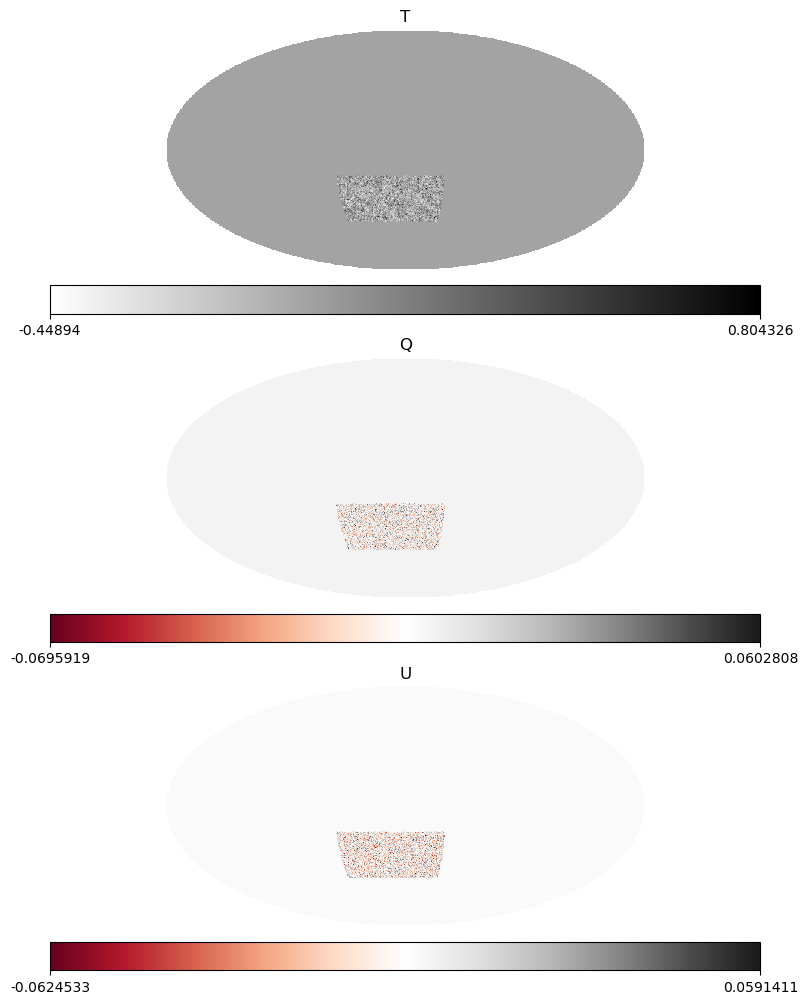

In [5]:
fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_maps[('POS', 1)], cmap='binary', title='T', hold=True)
#hp.visufunc.projplot(thetas[:200], phis[:200], 'ro')
plt.sca(ax[1])
hp.mollview(data_maps[('SHE', 1)][0], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(data_maps[('SHE', 1)][1], cmap='RdGy', title='U', hold=True)
plt.show()

In [6]:
alms = heracles.transform(fields, data_maps)
cls = heracles.angular_power_spectra(alms)
for key in cls.keys():
    r = cls[key].array
    n, m = np.atleast_2d(r).shape
    ell = np.arange(m)
    cls[key] = Result(r, axis=cls[key].axis, ell=ell)

In [7]:
mask_alms = heracles.transform(mask_fields, vis_maps)
mask_cls = heracles.angular_power_spectra(mask_alms)

In [8]:
from heracles.notebook import Progress

with Progress("mixmats") as progress:
    mms = mixing_matrices(
            fields, mask_cls, l1max=lmax, l2max=2*lmax, l3max=2*lmax+lmax,
            progress=progress,
        )

VBox()

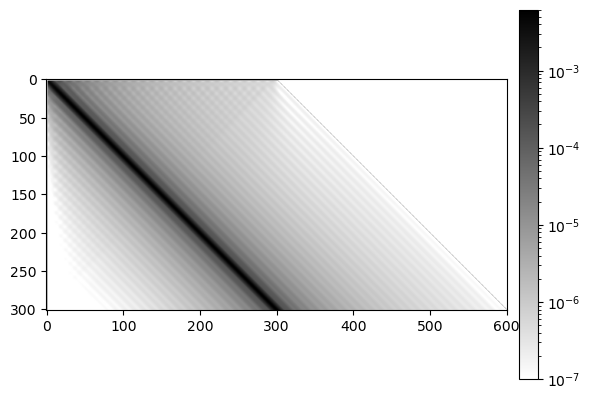

In [9]:
plt.imshow(
    mms["SHE", "SHE", 2, 2][0], cmap="binary", norm=mpl.colors.LogNorm(vmin=1e-7)
)
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

## Theory

In [10]:
import camb
from camb.sources import SplinedSourceWindow

In [11]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

In [12]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

In [13]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

In [14]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=2*lmax, raw_cl=True)

In [15]:
ell = np.arange(lmax + 1)
ell2 = np.arange(2*lmax + 1)
fl = -np.sqrt((ell2 + 2) * (ell2 + 1) * ell2 * (ell2 - 1))
fl /= np.clip(ell2 * (ell2 + 1), 1, None)

In [16]:
theory = {}
for i in range(1, nbins):
    for j in range(i, nbins):
        # all mixing matrix combinations
        theory["POS", "POS", i, j] = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        theory["POS", "SHE", i, j] = np.stack(
            [
                fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"],
                np.zeros_like(ell2),
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"],
                np.zeros_like(ell2),
            ]
        )
        if i == j:
            theory["SHE", "SHE", i, j] = np.stack(
                [
                    fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"],
                    np.zeros_like(ell2),
                    np.zeros_like(ell2),
                ]
            )
        else:
            theory["SHE", "SHE", i, j] = np.stack(
                [
                    fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"],
                    np.zeros_like(ell2),
                    np.zeros_like(ell2),
                    np.zeros_like(ell2),
                ]
            )

for key in theory.keys():
    c = cls[key]
    theory[key] = Result(theory[key], axis=c.axis, ell=ell2)

## Binning

In [17]:
nlbins = 10
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
B = np.diag(np.ones(lmax+1))
B = iolaus.bin2pt(B, ledges, 'B')
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

# Binned ls
q = B @ ell

## Plotting

In [18]:
def plot_clustering(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)
    fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "POS", i, j].ell[1:],
                cls["POS", "POS", i, j][1:],
                c="C0", lw=1.5, zorder=3.0, alpha=0.5
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "POS", i, j].ell[1:],
                theory["POS", "POS", i, j][1:],
                c="C0", lw=1.0, zorder=4.0
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-2e-7, 2e-4)

    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig

def plot_shear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)
    fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
               theory["SHE", "SHE", i, j].ell[2:],
               theory["SHE", "SHE", i, j][0, 2:],
               c="C0", lw=1.0, zorder=4.0
            )
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
               theory["SHE", "SHE", i, j].ell[2:],
               theory["SHE", "SHE", i, j][1, 2:],
               c="C1", lw=1.0, zorder=2.0
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-10, 5e-7)

    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig

def plot_clusteringxshear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins)
    fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

    for i in range(1, nbins):
        for j in range(1, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][0, 2:],
                c="C0", lw=1.0, zorder=4.0
            )
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][1, 2:],
                c="C1", lw=1.0, zorder=2.0
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-8e-6, 4e-8)

    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

    plt.show()

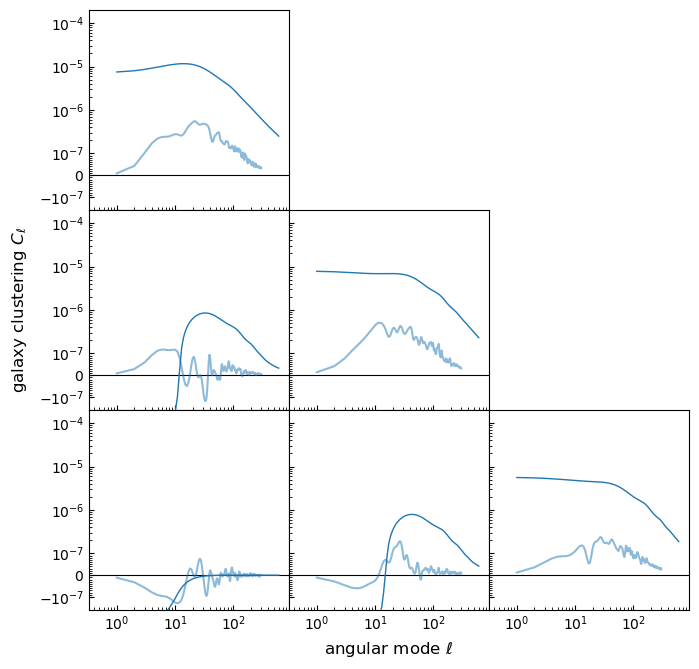

In [19]:
plot_clustering(cls, theory);

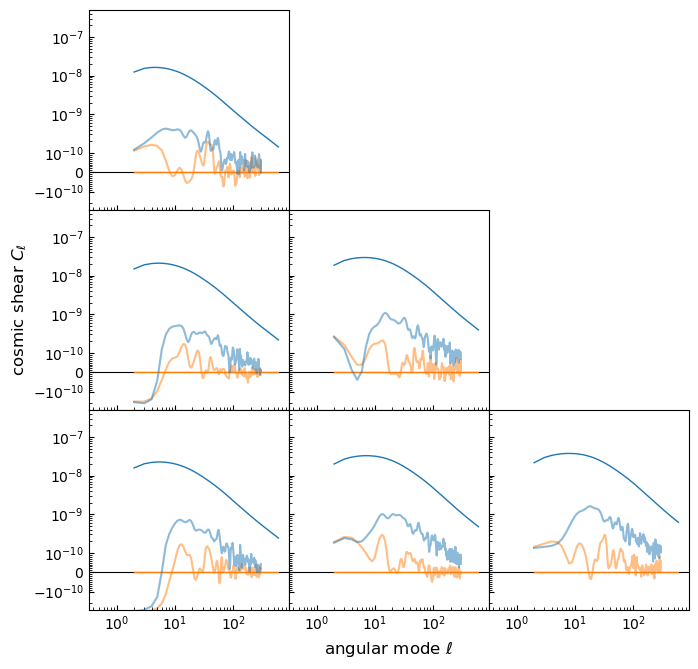

In [20]:
plot_shear(cls, theory);

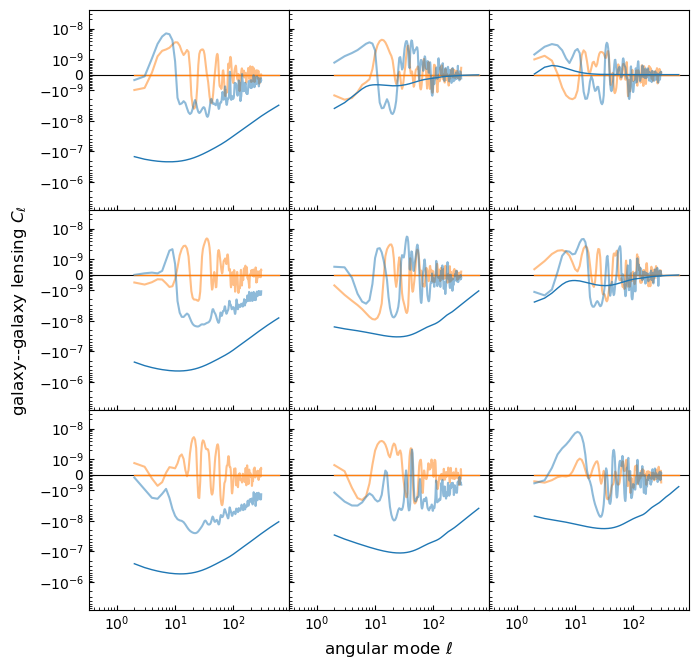

In [21]:
plot_clusteringxshear(cls, theory);

## Forward Model 

In Fourier space, we can relate an observed angular power spectrum $\tilde{C}_\ell$ to a theoretical full-sky angular power spectrum $C_\ell$ through the mixing matrix $M$, a matrix that contains the effect of the mask:
$$ \tilde{C}_\ell = M C_\ell $$

We find better results by considering a non-square square matrix such that the theory $C_\ell$'s are evaluated up to $2\ell_{max}$, where $\ell_{max}$ is the maximum multipole considered for the observed $\tilde{C}_\ell$.

We can modify the previous fudamental relation to express all Fourier space methods by considering a general matrix, A, such that:
$$ A \tilde{C}_\ell = A M C_\ell $$

Becuase we are often interested in the binned angular power spectrum, in the forward method $A = B$, where $B$ is the binning matrix.

To account for the E-B mixing, we compute the parial sky $C_\ell$  as:
$$ \tilde{C}_\ell^{EE} = B(M^{EE} C_\ell^{BB} + M^{BB} C_\ell^{EE}) \\
   \tilde{C}_\ell^{BB} = B(M^{EE} C_\ell^{EE} + M^{BB} C_\ell^{BB}) 
$$

Note that in our case $C_\ell^{BB} = 0$ by definition.

In [23]:
ft = heracles.forwards(theory, mms)

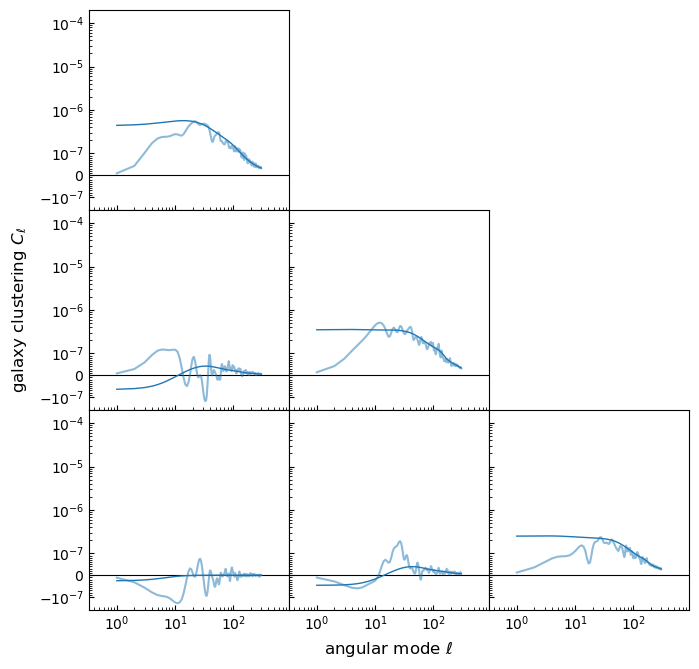

In [24]:
plot_clustering(cls, ft);

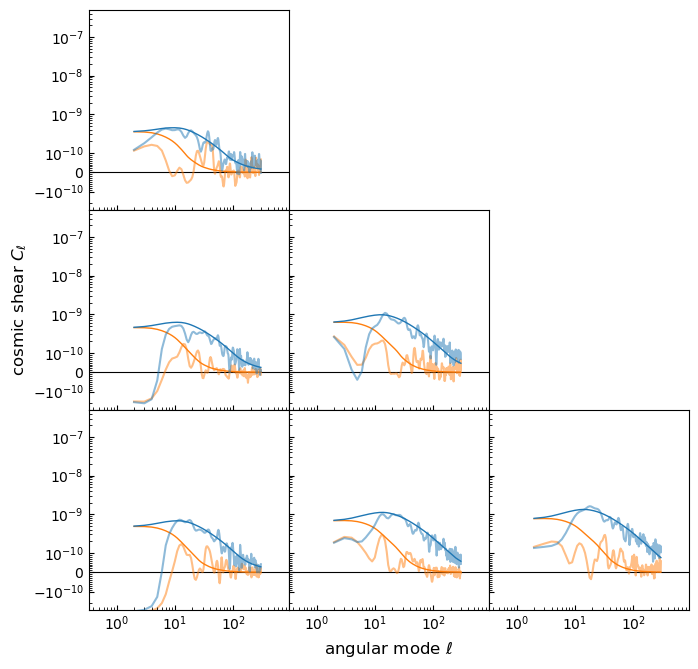

In [26]:
plot_shear(cls, ft);

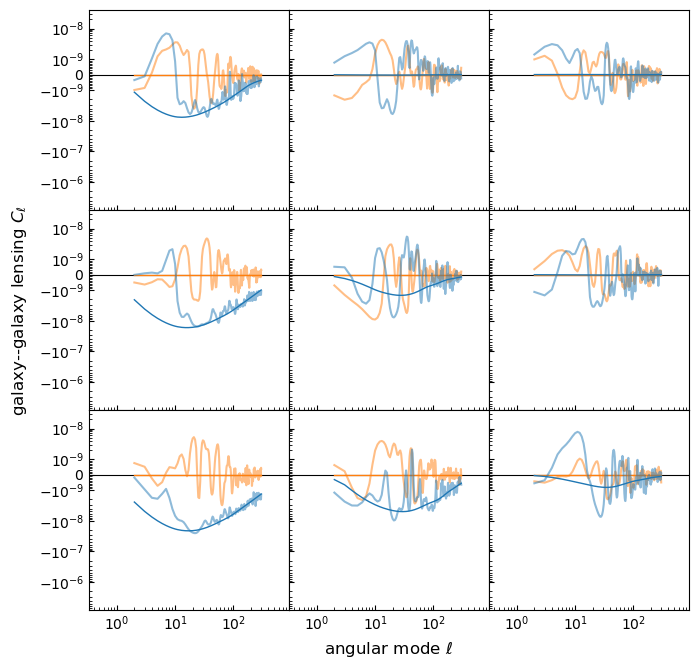

In [28]:
plot_clusteringxshear(cls, ft);

## Master Model

Similarly, the master method is equivalent to considering $A = (B M B^T)^{-1} B$.
Since the the initial steps of computing the master method $C_\ell$'s are the same as the forward method we reuse the previously computed $C_\ell$'s. However, we still need to apply the inverse binning matrix to get the final $C_\ell$'s.
Because we originally considered a non-square mixing matrix, we first crop the mixing matrix to the size of the data $C_\ell$'s we then bin. This operation is done in one single operation by applying the matrix $B_2$. 

Since the mixing of the E and B modes is already accounted in the first step when multiplying by the mixing matrix, we do not need to consider the mixing when inverting the binned mixing matrix.

In [ ]:
md, mt = heracles.master(cls, cls, mms, B, B2)

NameError: name 'data_cls' is not defined

In [ ]:
compsep_md = iolaus.compsep_cls(md)
compsep_mt = iolaus.compsep_cls(mt)

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = compsep_mt[proposed_key]
            d = compsep_md[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-5, 1e-2)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Master")
plt.show()

## Direct Inversion

The direct inversion method is equivalent to considering $A = B M^{-1}$.

To account for the E-B mixing, we compute the full sky $C_\ell^{E/B}$  as:
$$  \begin{bmatrix} 
 \langle C_l^{E\!E'} \rangle \\ \langle C_l^{B\!B'} \rangle  \end{bmatrix}
 =
\begin{bmatrix}
   M^{E\!E E'\!E'} & M^{B\!B E'\!E'} \\
   M^{E\!E B'\!B'} & M^{B\!B B'\!B'} 
\end{bmatrix}^{-1}
\begin{bmatrix} 
    \langle \tilde{C}_l^{E\!E'} \rangle \\ \langle \tilde{C}_l^{B\!B'} \rangle 
\end{bmatrix}
$$

In [ ]:
id = heracles.inversion(cls, mms, B, B2)
compsep_id = iolaus.compsep_cls(id)

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = B2 @ compsep_theory_cls[proposed_key]
            d = compsep_id[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-6, 1e-3)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Direct Inversion")
plt.show()

## Polspice

In the Polspice method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [ ]:
mask_cls = iolaus.mask2cls(mask, nside, lmax)
dnp = heracles.natural_unmixing(data_cls, mask_cls, B, patch_hole=True)
compsep_dnp = iolaus.compsep_cls(dnp)

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(3*2, 3*2))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1[0], s2[0], s1[1], s2[1])
        print(proposed_key)
        if i <= j: 
            t = compsep_theory_cls[proposed_key]
            d = compsep_dnp[proposed_key]
            axis[j, i].plot(q, d, "o-", label="Data Cls")
            axis[j, i].plot(q, B2 @ t, 'o-', label="Theory Cls")
            axis[i, i].set_xscale('log')
            axis[j, i].set_yscale('log')
            axis[j, i].set_title(f"{proposed_key}", y=0.85)
            axis[j, i].grid()
            axis[j, i].set_xlim(5, 2*lmax)
            if i == 0 and j == 0:
                axis[j, i].set_ylim(1e-6, 1e-3)
            else:
                axis[j, i].set_ylim(1e-12, 1e-6)
            if i>0:
                axis[j, i].set_yticklabels([])
        else:
            axis[j, i].axis('off')
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Angular Power Spectra $C_\\ell$", x=-0.1, ha="right")
fig.suptitle("Naive Polspice")

plt.show()